In [1]:
# Import necessary modules
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import *

## Control Inputs

In [ ]:
'''
# Best GA params
IF=1236.7362895452
IA=4.9896961931
FF=803.2474625247
FA=76.7713014035

irrigation_frequency = IF # Irrigate once every X hours
irrigation_amount    = IA # with X inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = FF # Fertilize once every X hours
fertilizer_amount    = FA # with X lbs per fertilization (goal is 355 lbs over season)

'''
# Farmer Best practice
irrigation_frequency = 24 * 7  # Irrigate once every week
irrigation_amount    = 1       # with 1 inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = 24 * 30 # Fertilize once every month
fertilizer_amount    = 90      # with 90 lbs per fertilization (goal is 355 lbs over season)


## Model Parameters

In [3]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 0.1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = True,
    verbose          = True
)

In [4]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [5]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [6]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [7]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Cost function weights

In [8]:
ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_irrigation    = ga_params.weight_irrigation
weight_fertilizer    = ga_params.weight_fertilizer
weight_height        = ga_params.weight_height
weight_leaf_area     = ga_params.weight_leaf_area

## Input Disturbances

In [9]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [10]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = 0.5 * hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(), # let's say it's a drought year
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Get hourly control inputs from irrigation/fertilizer amount/frequency

In [11]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(irrigation_frequency).astype(int)):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(fertilizer_frequency).astype(int)):
    hourly_fertilizer[t] = fertilizer_amount

## Plot inputs and disturbances

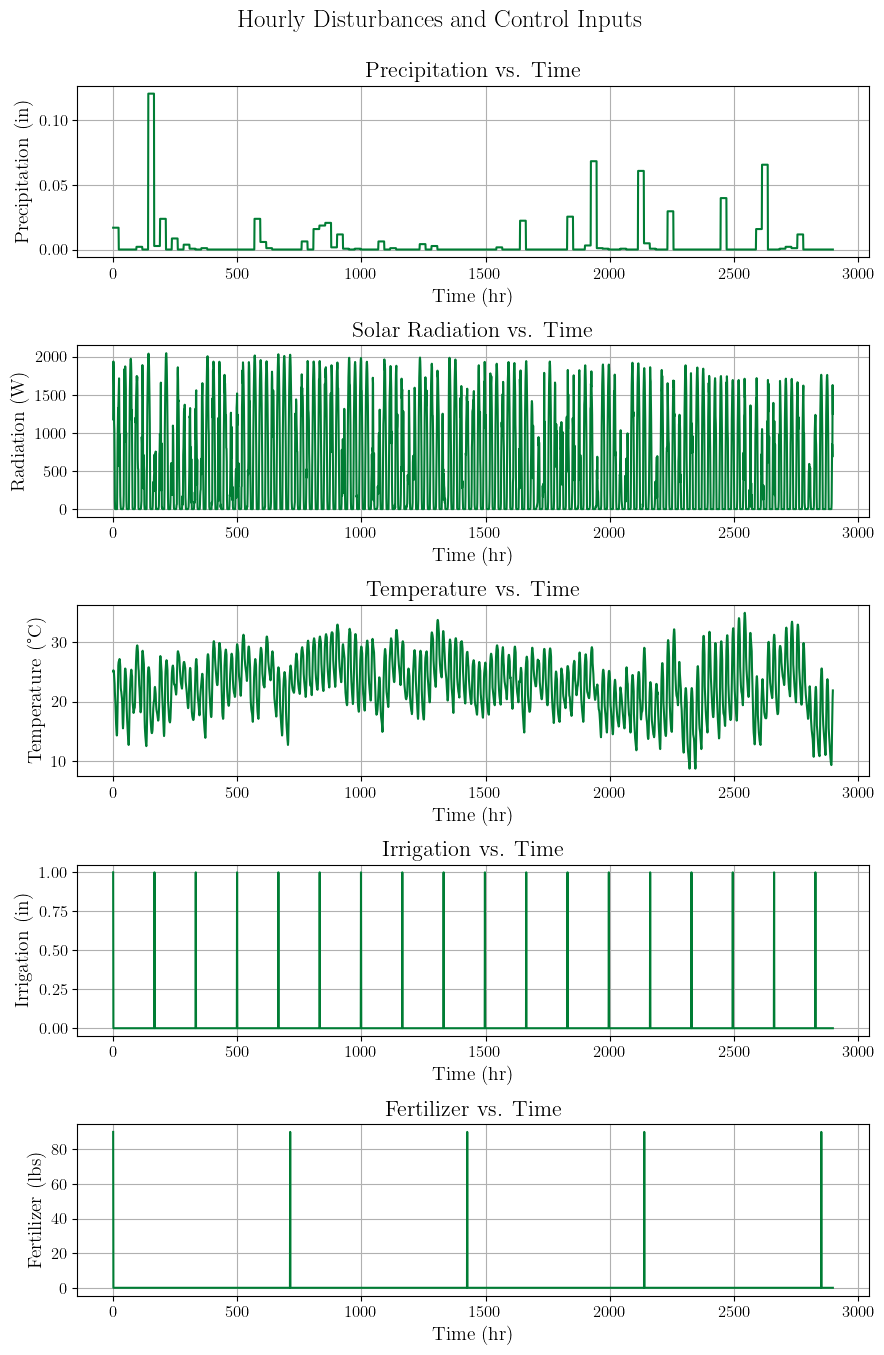

In [12]:
plot_hourly_inputs(
    input_disturbances,
    hourly_irrigation,
    hourly_fertilizer
)

In [13]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly

hourly_irrigation = np.zeros(simulation_hours)
step_if = max(1, int(np.ceil(irrigation_frequency)))
hourly_irrigation[::step_if] = irrigation_amount
irrigation = get_sim_inputs_from_hourly(hourly_irrigation, model_params.dt, simulation_hours, mode='split')

hourly_fertilizer = np.zeros(simulation_hours)
step_ff = max(1, int(np.ceil(fertilizer_frequency)))
hourly_fertilizer[::step_ff] = fertilizer_amount
fertilizer = get_sim_inputs_from_hourly(hourly_fertilizer, model_params.dt, simulation_hours, mode='split')

temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

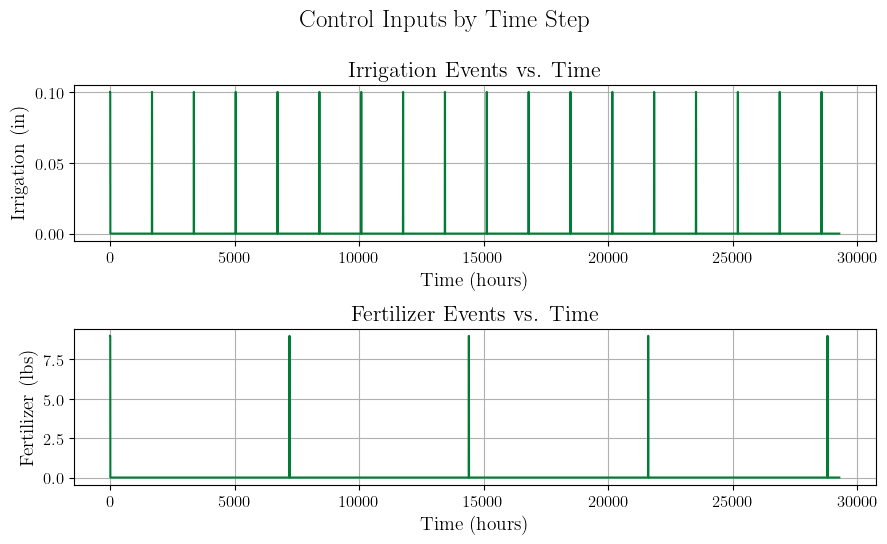

In [14]:
plot_control_inputs(
    irrigation,
    fertilizer
)

## Optimal/Typical Values

In [15]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water       * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer  * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation   * model_params.dt
)

## GA Params (just to use Member class)

In [16]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams()

## Simulation of Plant Growth over Season

In [17]:
# Construct an instance of the Member class and get the cost
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
)
member.get_cost()

-859.0129465426905

In [18]:
# Read results from the output csv file
output = pd.read_csv('output_get_cost.csv')

h = output['h'].to_numpy()
A = output['A'].to_numpy()
N = output['N'].to_numpy()
c = output['c'].to_numpy()
P = output['P'].to_numpy()

raw_water       = output['raw_water'].to_numpy()       # (same as irrigation + precipitation)
raw_fertilizer  = output['raw_fertilizer'].to_numpy()  # (same as fertilizer)
raw_temperature = output['raw_temperature'].to_numpy() # (same as temperature)
raw_radiation   = output['raw_radiation'].to_numpy()   # (same as radiation)

delayed_water       = output['delayed_water'].to_numpy()
delayed_fertilizer  = output['delayed_fertilizer'].to_numpy()
delayed_temperature = output['delayed_temperature'].to_numpy()
delayed_radiation   = output['delayed_radiation'].to_numpy()

cumulative_water       = output['cumulative_water'].to_numpy()
cumulative_fertilizer  = output['cumulative_fertilizer'].to_numpy()
cumulative_temperature = output['cumulative_temperature'].to_numpy()
cumulative_radiation   = output['cumulative_radiation'].to_numpy()

cumulative_divergence_water       = output['cumulative_divergence_water'].to_numpy()
cumulative_divergence_fertilizer  = output['cumulative_divergence_fertilizer'].to_numpy()
cumulative_divergence_temperature = output['cumulative_divergence_temperature'].to_numpy()
cumulative_divergence_radiation   = output['cumulative_divergence_radiation'].to_numpy()

nuWs = output['nuW'].to_numpy()
nuFs = output['nuF'].to_numpy()
nuTs = output['nuT'].to_numpy()
nuRs = output['nuR'].to_numpy()

ah_hat = output['ah_hat'].to_numpy()
aA_hat = output['aA_hat'].to_numpy()
aN_hat = output['aN_hat'].to_numpy()
ac_hat = output['ac_hat'].to_numpy()
aP_hat = output['aP_hat'].to_numpy()

kh_hat = output['kh_hat'].to_numpy()
kA_hat = output['kA_hat'].to_numpy()
kN_hat = output['kN_hat'].to_numpy()
kc_hat = output['kc_hat'].to_numpy()
kP_hat = output['kP_hat'].to_numpy()

## Plot crop growth results

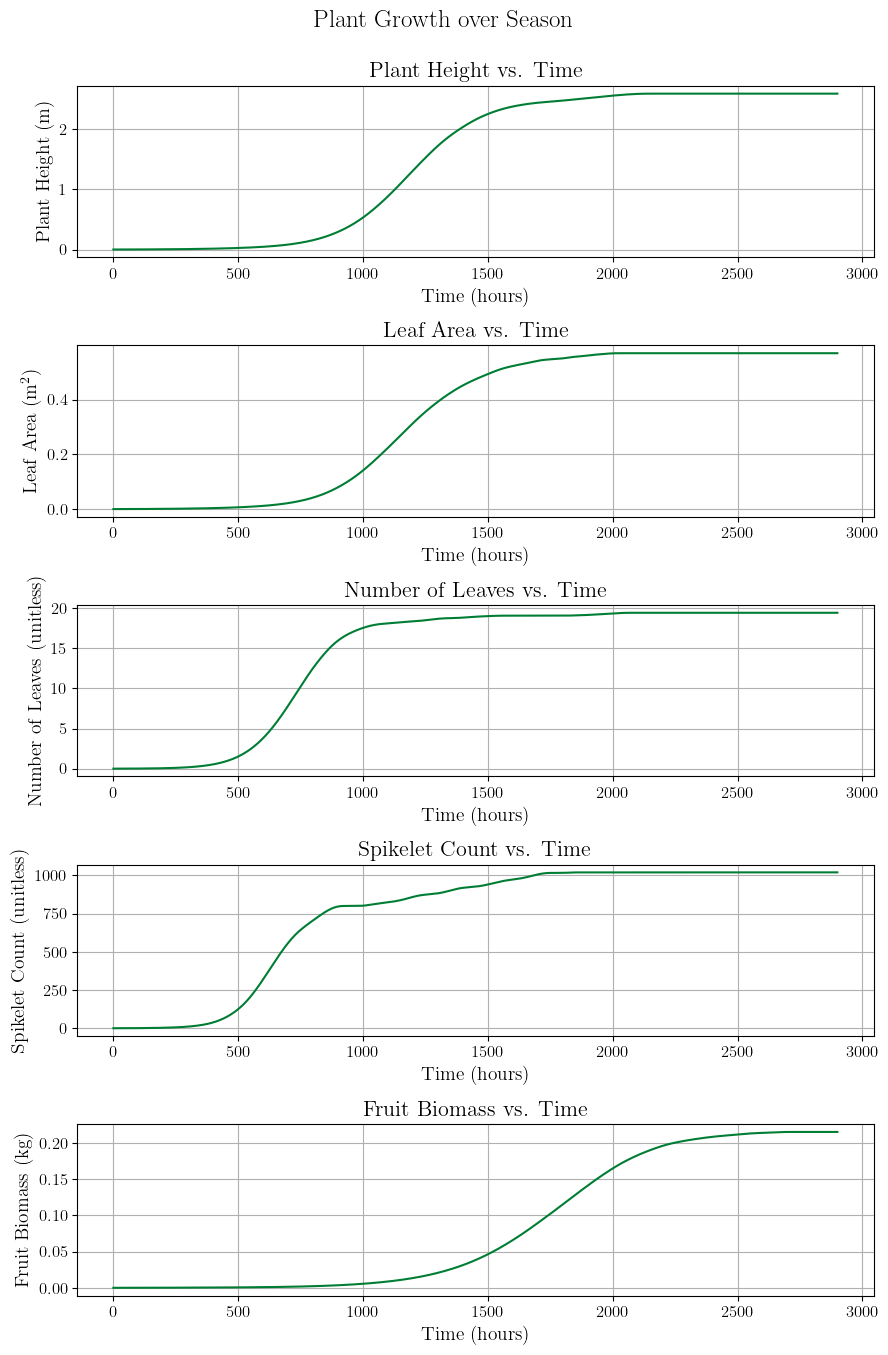

In [19]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

In [20]:
profit = weight_fruit_biomass * P[-1] + weight_height * h[-1] + weight_leaf_area * A[-1]
expenses = (weight_irrigation * np.sum(hourly_irrigation)
            + weight_fertilizer * np.sum(hourly_fertilizer))
revenue = profit - expenses

print(f'weight_fruit_biomass: {weight_fruit_biomass}')
print(f'weight_irrigation: {weight_irrigation}')
print(f'weight_fertilizer: {weight_fertilizer}')

print(f'\n')

print(f'Height: {h[-1]}')
print(f'Leaf area: {A[-1]}')
print(f'Fruit biomass: {P[-1]}')

print(f'\n')

print(f'Profit: ${profit:.2f}')
print(f'Irrigation used (in): {np.sum(hourly_irrigation):.2f}, irrigation expense: ${weight_irrigation * np.sum(hourly_irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(hourly_fertilizer):.2f}, fertilizer expense: ${weight_fertilizer * np.sum(hourly_fertilizer):.2f}')
print(f'Expenses: ${expenses:.2f}')
print(f'Revenue: ${revenue:.2f}')

weight_fruit_biomass: 4450
weight_irrigation: 2.0
weight_fertilizer: 0.614


Height: 2.593889368854291
Leaf area: 0.56894109883789
Fruit biomass: 0.2153268499736279


Profit: $1171.31
Irrigation used (in): 18.00, irrigation expense: $36.00
Fertilizer used (lbs): 450.00, fertilizer expense: $276.30
Expenses: $312.30
Revenue: $859.01


## Plot input and disturbance evolution with delays taken into account

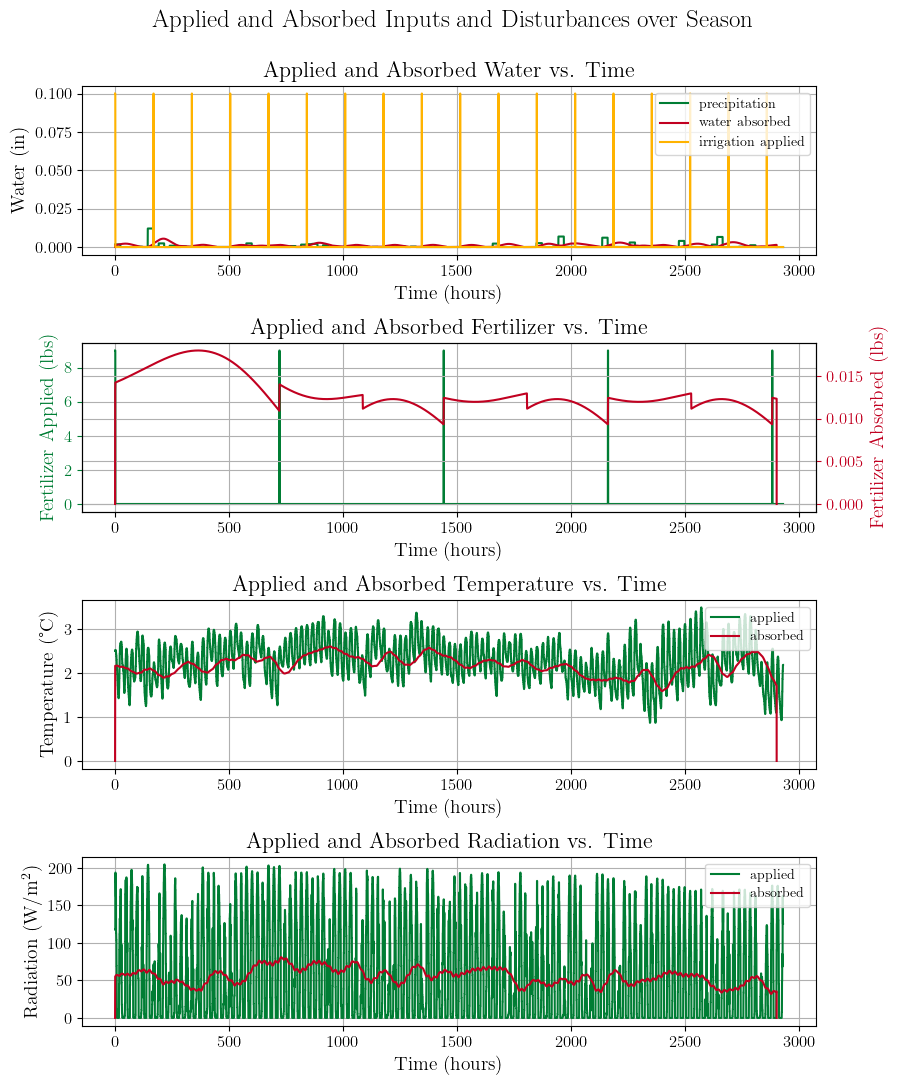

In [21]:
plot_applied_vs_absorbed(
        irrigation,
        precipitation,
        delayed_water,
        fertilizer,
        delayed_fertilizer,
        temperature,
        delayed_temperature,
        radiation,
        delayed_radiation
)

## Plot cumulative value evolution

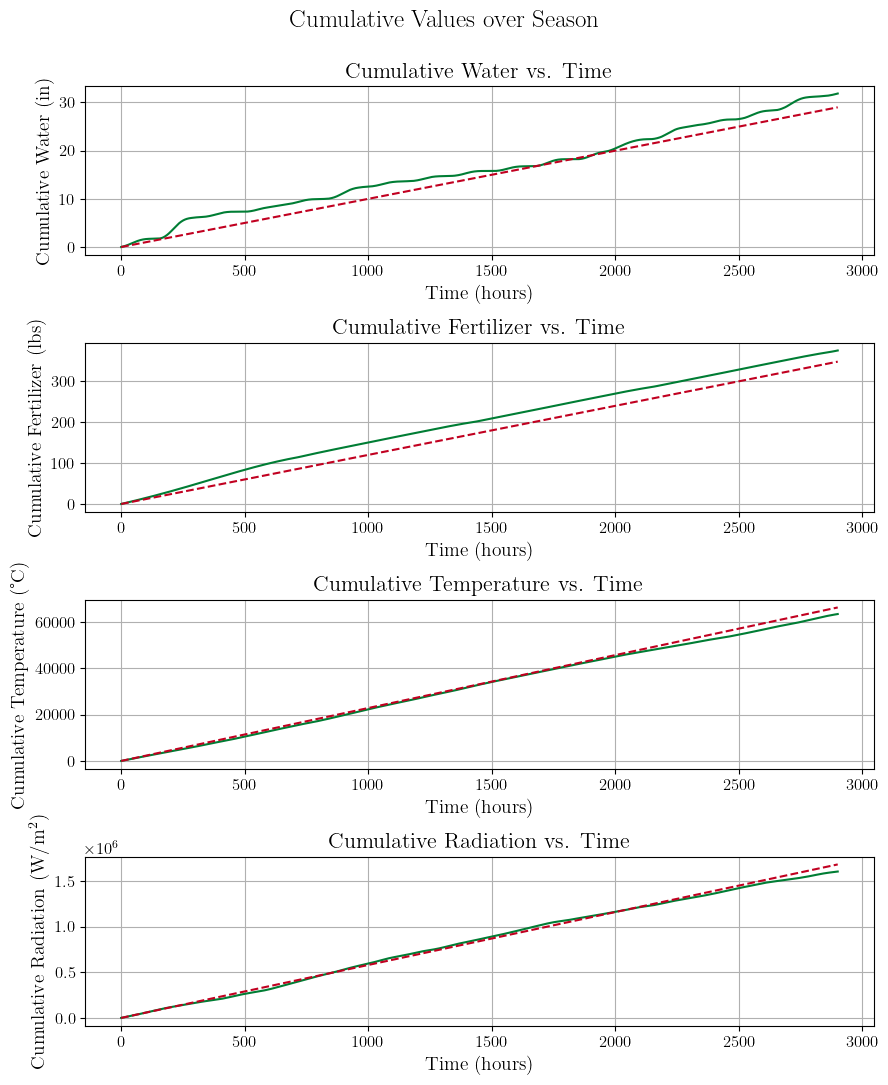

In [22]:
plot_cumulative_values(
    cumulative_water,
    cumulative_fertilizer,
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

## Plot the deltas between actual and expected cumulative value

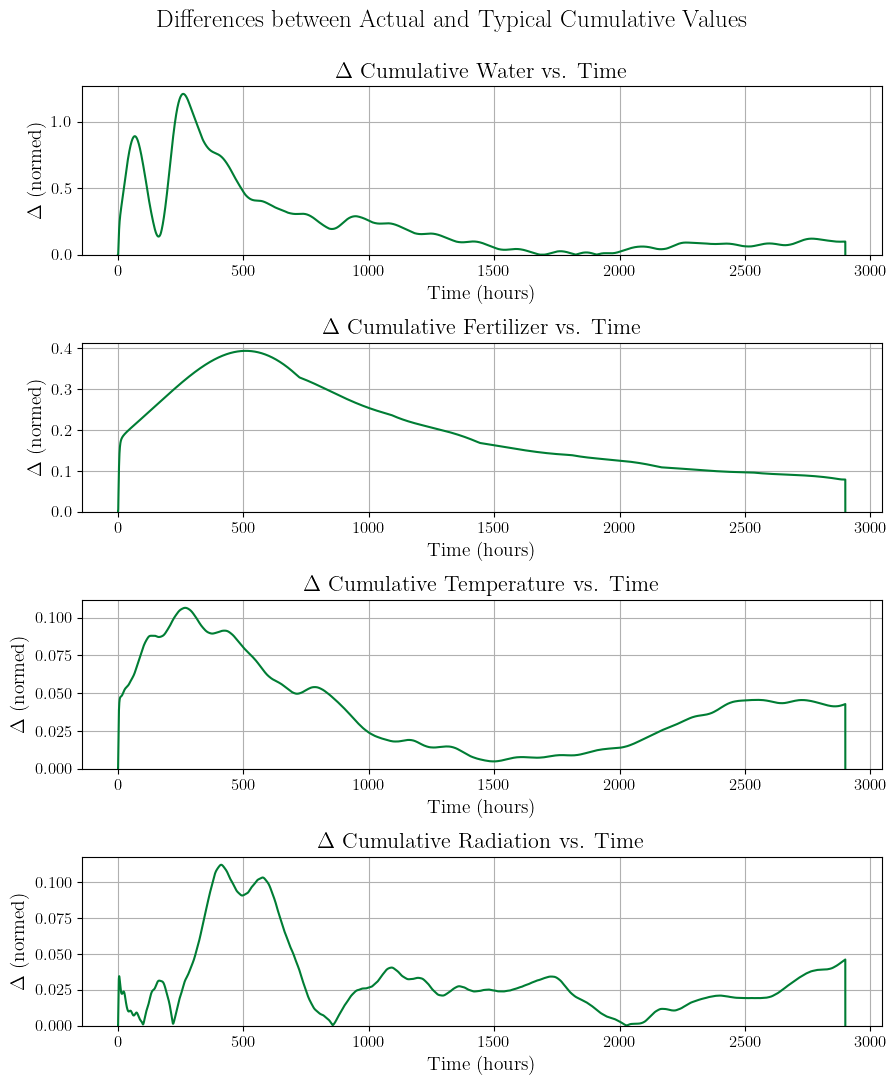

In [23]:
plot_actual_vs_expected_cumulatives(
    cumulative_divergence_water,
    cumulative_divergence_fertilizer,
    cumulative_divergence_temperature,
    cumulative_divergence_radiation
)

## Plot nutrient factor evolution

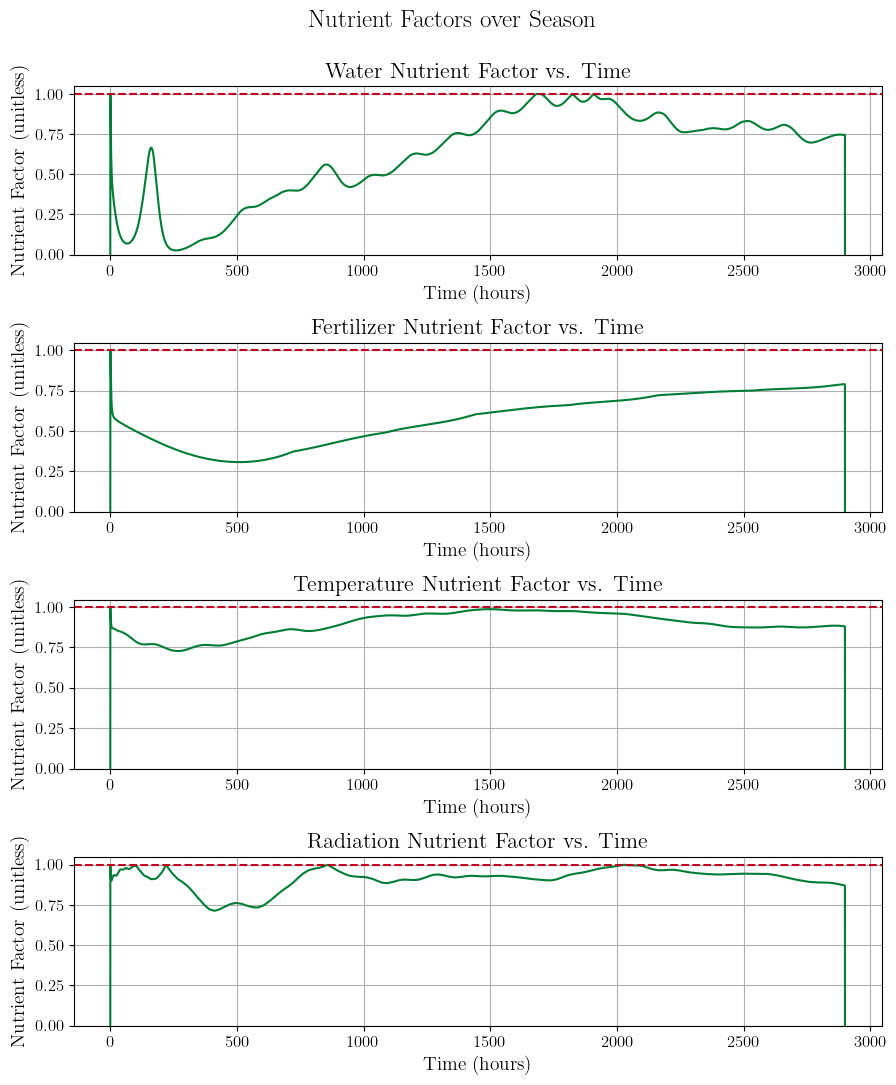

In [24]:
plot_nutrient_factor_evolution(
    [nuWs],
    [nuFs],
    [nuTs],
    [nuRs]
)

## Plot growth rates over time

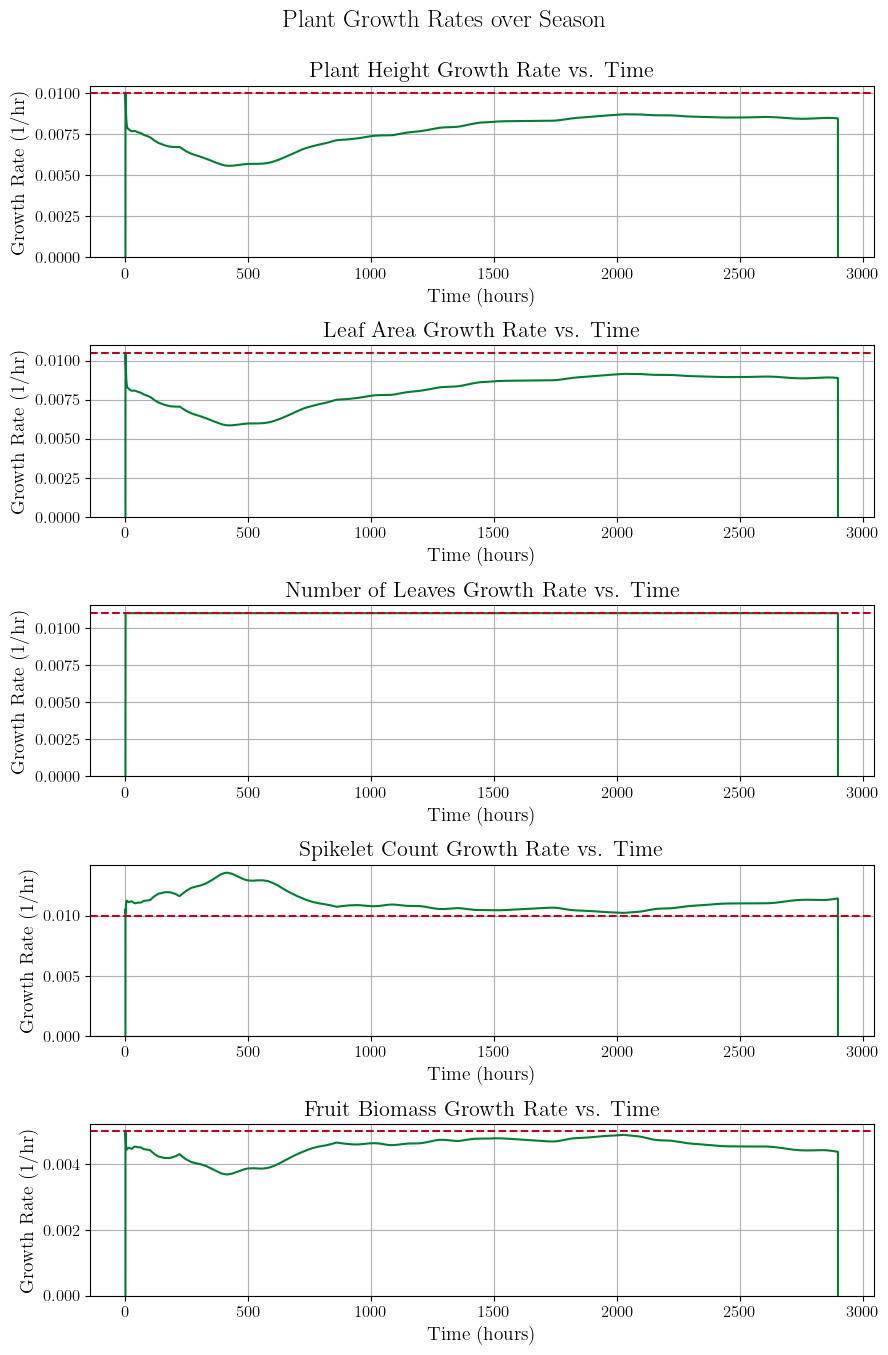

In [25]:
plot_growth_rate_evolution(
        growth_rates,
        [ah_hat],
        [aA_hat],
        [aN_hat],
        [ac_hat],
        [aP_hat],
)

## Plot carrying capacities over time

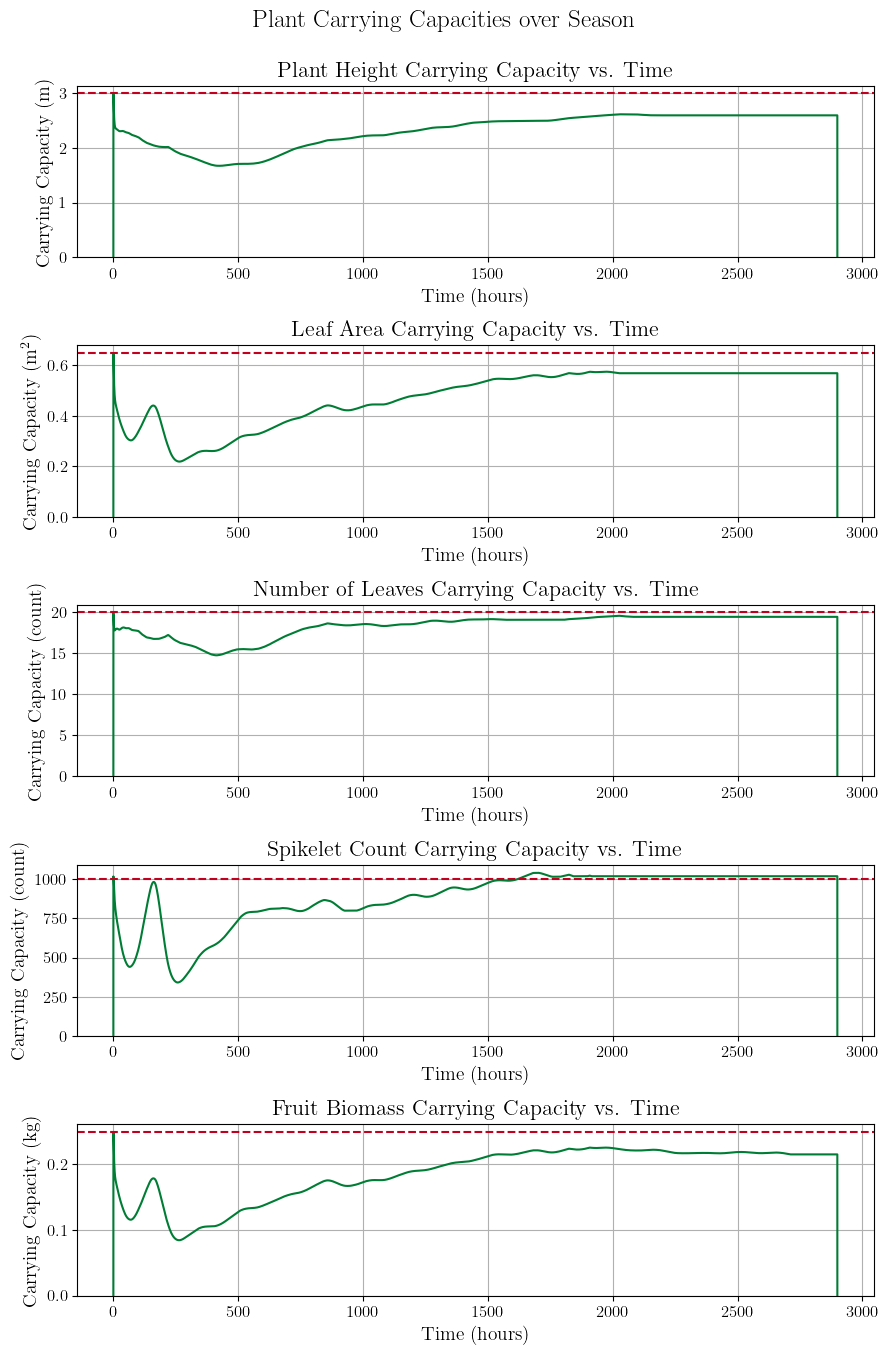

In [26]:
plot_carrying_capacity_evolution(
        carrying_capacities,
        [kh_hat],
        [kA_hat],
        [kN_hat],
        [kc_hat],
        [kP_hat]
)